In [1]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import pandas as pd

In [2]:
url = "http://www.chakoteya.net/NextGen/episodes.htm"
url_base = "http://www.chakoteya.net/NextGen/"
html = urlopen(url)
soup = BeautifulSoup(html)

In [3]:
lsts = soup.find_all("td")
transcript_links = []
for ol in lsts:
    a = (ol.find_all("a"))
    for link in a:
        transcript_links.append(url_base + link['href'])
# drop the last 2
transcript_links = list(set(transcript_links[0:-2]))
len(transcript_links)

176

In [4]:
import re
transcript_holder = []
episodes = [] # write now the code is not properly grabbing the transcript titles per line
for link in transcript_links:
    html = urlopen(link)
    soup = BeautifulSoup(html)
    try:
        title = soup.find('p').find('b').get_text().replace('\n',' ')
    except:
        try:
            title = soup.find('font').find('b').get_text().replace('\n', ' ')
        except:
            print(link)
        
    # first remove all unwanted newlines
    # replace all the <br> tags with \n
    for br in soup.find_all("br"):
        br.replace_with("@@@")
    old_transcript = soup.find("div").find_all('p')
    transcript_holder.append(old_transcript)
    episodes.append(title)

In [5]:
character_lines_df = pd.DataFrame(columns=['Character', 'Line', 'Episode'])
clean_list = ['', ' ', ')', '.', '8.27', '>', ']', 'ibi']
for i in range(len(transcript_holder)):
    transcript = transcript_holder[i]
    title = episodes[i]
    transcript = [re.sub(r'(\(|\[)[^\(\)\[\]]*(\)|\])', '',p.get_text().replace('\n', ' ')).split('@@@') for p in transcript]
    transcript = [l.rstrip().lstrip() for p in transcript for l in p if l.rstrip().lstrip() not in clean_list]
    transcript = [l for l in transcript if not l.startswith('(') and not l.endswith(')')]

    # we want to split the lines into two lists
    # the first element is the character
    # the second is the line
    # however, incase there are ':' in the lines
    # we will rejoin the later element
    def split_line(line):
        line = line.lstrip().rstrip()
        if line.lower().startswith('captain\'s log') or line.startswith('Captain\'s log'):
            line = 'PICARD: ' + line
        if line.lower().startswith('chief medical officer\'s log'):
            line = 'Chief Medical Officer:' + line
        if line.startswith('Captain\'s personal log'):
            line = 'CAPTAIN:' + line
        if line.lower().startswith('acting captain'):
            line = 'Acting Captain:' + line
        if line.startswith("COMPUTER  Sixteen, fifteen"):
            line = "COMPUTER: Sixteen, fifteen"
        if line.startswith("Chief Engineer\'s log"):
            line = 'Chief Engineer:' + line
        if line.startswith("Enterprise log, supplemental. First Officer reporting.") or line.lower().startswith('first officer\'s'):
            line = "First Officer:" + line
        if line.startswith("Lieutenant Worf, personal log"):
            line = "WORF:" + line
        if line.lower().startswith("medical log") or line.lower().startswith('medical officer\'s log'):
            line = "Medical Officer:" + line
        if line.lower().startswith("military log"):
            line = "Log:" + line
        if line.lower().startswith("second officer's "):
            line = "Second Officer:"+line
        line = line.replace('Chief Medical Officer\'s log,', 'Chief Medical Officer: Chief Medical Officer\'s log,')
        line = line.replace('PICARD  This is a confession given by me', 'PICARD: This is a confession given by me')
        line = line.replace('Personal log, Commander William Riker. ', 'RIKER: Personal log, Commander William Riker. ')
        line = line.replace('Personal log, stardate 41153.7. Recorded ', 'Log: Personal log, stardate 41153.7. Recorded ')
        line = line.replace('Second Officers personal log', 'Second Officer: Second Officers personal log')
        line = line.replace('Ship\'s log', 'Log: Ship\'s log')
        line = line.replace('Stardate 41235.32', 'PICARD: Stardate 41235.32')
        string_list = line.split(':')
        new_str_lst = []
        new_str_lst.append(string_list.pop(0))
        new_str_lst.append("".join(string_list).rstrip().lstrip())
        return new_str_lst

    transcript = [split_line(line) for line in transcript]    

    # make into a dataframe
    try:
        df = pd.DataFrame(transcript, columns=['Character', 'Line'])
        df['Episode'] = title
    except:
        print(title, transcript)
        break
    # add to the main df
    character_lines_df = character_lines_df.append(df, ignore_index=True)
character_lines_df.Character = character_lines_df.Character.apply(lambda x: x.lstrip().rstrip())
print(len(character_lines_df))
# character_lines_df.head()
# character_lines_df[character_lines_df.Character.str.startswith('ibi')]
set(character_lines_df.Character.tolist())

63838


{"'How relaxing the sound of the waves is,' you said.",
 'A singular development of cat communications',
 'A tail is quite essential for your acrobatic talents.',
 'AARON',
 'ACCOLAN',
 'ADMINISTRATOR',
 'ADONIS',
 'AIDE',
 'AJUR',
 'ALANS',
 'ALBERT',
 'ALEXANA',
 'ALEXANDER',
 'ALEXANDRA',
 'ALIEN',
 'ALIEN 1',
 'ALIEN 1+4',
 'ALIEN 2',
 'ALIEN 3',
 'ALIEN 4',
 'ALKAR',
 'ALL',
 'ALLENBY',
 'ALRIK',
 'ALYSSA',
 'AMANDA',
 'AMARIE',
 'ANAYA',
 'ANNA',
 'ANNE',
 'ANNIE',
 'ANTEDEAN',
 'ANTEDEANS',
 'ANTHWARA',
 'ANTICAN',
 'ANYA',
 'APGAR',
 'APPRENTICE',
 'AQUIEL',
 "ARD'RIAN",
 'ARDRA',
 'ARGYLE',
 'ARIANA',
 'ARIEL',
 'ARMSTRONG',
 'ARMUS',
 'ARRIDOR',
 'AUDIENCE',
 'Acting Captain',
 'An endothermic quadruped, carnivorous by nature.',
 'And now the conclusion',
 'And now, the conclusion.',
 'And though you are not sentient, Spot, and do not comprehend',
 'And we watched the occurrence, in silence, instead.',
 'And when not being utilised to aid in locomotion',
 'And, Commander, it 

In [ ]:
character_lines_df[['Character', 'Line']].to_csv("ST_TNG_lines.csv", index=False, sep=":")
character_lines_df[character_lines_df.Character != "Captain\s log"][['Character', 'Line']].to_csv("ST_TNG_lines_noCaptLogs.csv", sep=":", index=False)
set(character_lines_df.Character.tolist())
# character_lines_df[character_lines_df.Character.str.startswith("(")] #63858

In [8]:
# save the thing
character_lines_df.to_pickle("scraped_lines.pkl")
character_lines_df.head()

,Character,Line,Episode
0,WORF,"Personal log, stardate 47391.2. I am returning...",Parallels
1,RIKER,It looks like we're going to have to head into...,Parallels
2,WORF,"Hmm? Yes, sir.",Parallels
3,RIKER,You seem awfully tense for a man who just came...,Parallels
4,WORF,Today is my birthday.,Parallels


In [16]:
# read in the manually editted lines
with open('ST_TNG_lines - Copy.txt','r') as infile:
    cleaned_lines = infile.readlines()
cleaned_lines[0:5]

['Character:Line\n',
 'RIKER:Someone sure stripped this place.\n',
 "WORF:The reactor's gone.\n",
 "RIKER:No wonder they didn't answer our hail for two days. Nothing here to answer with.\n",
 'DATA:Commander, I am detecting life signs from behind that door.\n']

In [17]:
cleaned_lines = cleaned_lines[1:]
for i in range(len(cleaned_lines)):
    line = cleaned_lines[i]
    line = line.replace('\n','')
    line = line.split(':')
    new_str_lst = []
    new_str_lst.append(line.pop(0))
    new_str_lst.append("".join(line).rstrip().lstrip())
    cleaned_lines[i] = new_str_lst
cleaned_lines[0:5]

[['RIKER', 'Someone sure stripped this place.'],
 ['WORF', "The reactor's gone."],
 ['RIKER',
  "No wonder they didn't answer our hail for two days. Nothing here to answer with."],
 ['DATA', 'Commander, I am detecting life signs from behind that door.'],
 ['RIKER', 'Worf!']]

In [18]:
cleaned_df = pd.DataFrame(cleaned_lines, columns=['Character', 'Line'])
cleaned_df.head()

,Character,Line
0,RIKER,Someone sure stripped this place.
1,WORF,The reactor's gone.
2,RIKER,No wonder they didn't answer our hail for two ...
3,DATA,"Commander, I am detecting life signs from behi..."
4,RIKER,Worf!


In [30]:
# Grab only specific characters for twitter feed
cleaned_df.groupby(['Character'])['Line'].count().reset_index(name='count').sort_values(['count'], ascending=False).head()

,Character,count
554,PICARD,12595
606,RIKER,7396
154,DATA,6292
391,LAFORGE,4578
791,WORF,3820


In [33]:
cleaned_df[cleaned_df.Character == 'PICARD']['Line'].to_csv("Picard_lines.csv", index=False, sep=":")
cleaned_df[cleaned_df.Character == 'DATA']['Line'].to_csv("DATA_lines.csv", index=False, sep=":")
cleaned_df[cleaned_df.Character == 'WORF']['Line'].to_csv("WORF_lines.csv", index=False, sep=":")

In [35]:
# LSP word cloud!!
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
%matplotlib inline

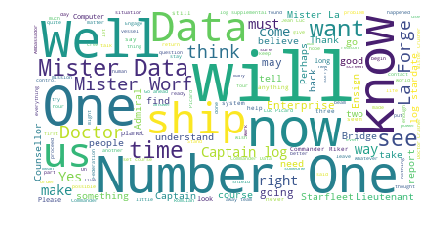

In [37]:
def make_wc(text, cont_color, bkg,cw):
    # Create and generate a word cloud image:
    wordcloud = WordCloud(max_font_size=70, max_words=150, 
                          background_color=bkg,
                         contour_width=cw, contour_color=cont_color).generate(text)

    # Display the generated image:
    plt.figure(figsize=[7,7])
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
text = " ".join(cleaned_df[cleaned_df.Character == 'PICARD']['Line'].tolist())
make_wc(text,'violet', "white",3)

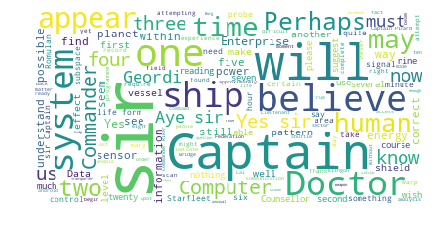

In [38]:
text = " ".join(cleaned_df[cleaned_df.Character == 'DATA']['Line'].tolist())
make_wc(text,'violet', "white",3)

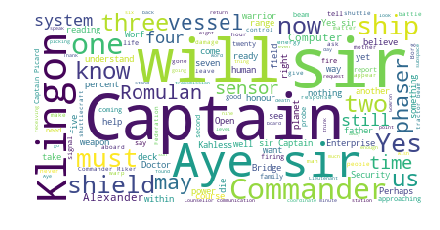

In [39]:
text = " ".join(cleaned_df[cleaned_df.Character == 'WORF']['Line'].tolist())
make_wc(text,'violet', "white",3)

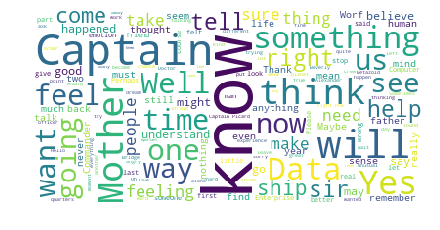

In [40]:
text = " ".join(cleaned_df[cleaned_df.Character == 'TROI']['Line'].tolist())
make_wc(text,'violet', "white",3)

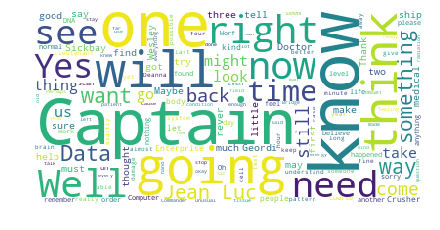

In [41]:
text = " ".join(cleaned_df[cleaned_df.Character == 'CRUSHER']['Line'].tolist())
make_wc(text,'violet', "white",3)